In [2]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
import Template
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Template = Template.Template()


# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')
# import the data from all sheets of the Excel file

df0 = pd.read_excel(data_path, sheet_name=0)
df1 = pd.read_excel(data_path, sheet_name=1)
df2 = pd.read_excel(data_path, sheet_name=2)
df3 = pd.read_excel(data_path, sheet_name=3)
df4 = pd.read_excel(data_path, sheet_name=4)
df10 = pd.read_excel(data_path, sheet_name=10)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)

df0_NotFEH0 = df0[df0['Tratamiento'] != 'Fus_EH']

df_NotFEH0 = pd.concat([df0_NotFEH0, df1, df2, df3], ignore_index=True)

print(df_NotFEH0['Tratamiento'].value_counts())


Tratamiento
Fus_EH_Ral    120
Ral_EH        120
Fusarium      119
E_Hidrico     118
Control       117
Ralstonia     116
Ral_Fus       116
Fus_EH         88
Name: count, dtype: int64


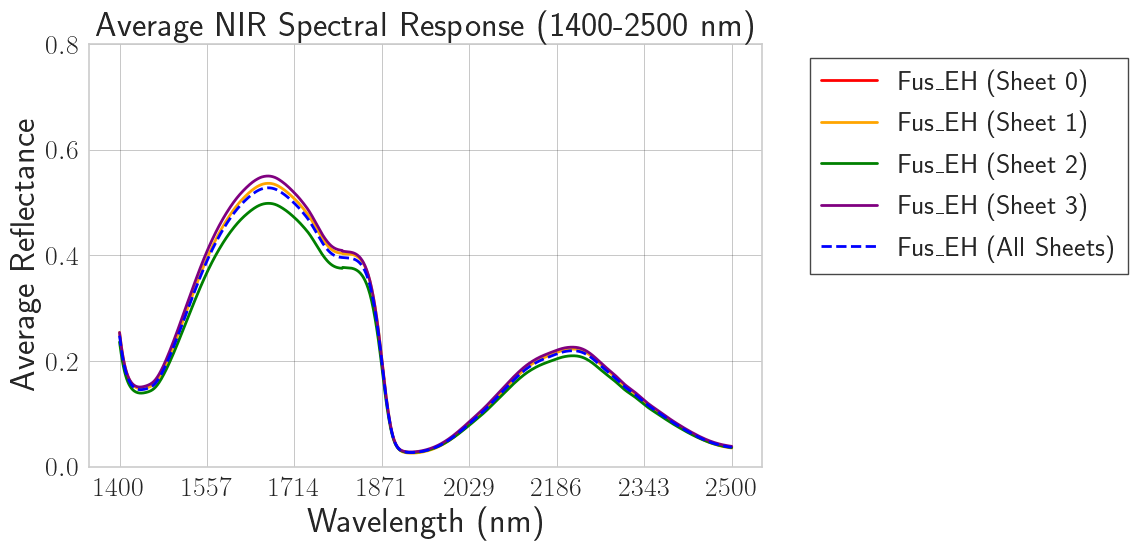

In [2]:
# Create a single figure for all plant indices
plt.figure(figsize=(12, 6))

# Filter wavelengths between 1400 and 2500
wavelengths = [int(col) for col in df0.columns if str(col).isdigit() and 1400 <= int(col) <= 2500]

fus_df_0 = df0[df0['Tratamiento'] == 'Fus_EH'][wavelengths].mean()
plt.plot(wavelengths, fus_df_0, label='Fus_EH (Sheet 0)', color='red')

fus_df_1 = df1[df1['Tratamiento'] == 'Fus_EH'][wavelengths].mean()
plt.plot(wavelengths, fus_df_1, label='Fus_EH (Sheet 1)', color='orange')

fus_df_2 = df2[df2['Tratamiento'] == 'Fus_EH'][wavelengths].mean()
plt.plot(wavelengths, fus_df_2, label='Fus_EH (Sheet 2)', color='green')

fus_df_3 = df3[df3['Tratamiento'] == 'Fus_EH'][wavelengths].mean()
plt.plot(wavelengths, fus_df_3, label='Fus_EH (Sheet 3)', color='purple')


fus_df = df[df['Tratamiento'] == 'Fus_EH'][wavelengths]
plt.plot(wavelengths, fus_df.mean(), label='Fus_EH (All Sheets)', color='blue', linewidth=2, linestyle='--')



# Customize plot
plt.xlabel('Wavelength (nm)')
plt.ylabel('Average Reflectance')
plt.title('Average NIR Spectral Response (1400-2500 nm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.linspace(min(wavelengths), max(wavelengths), 8))

# Set y-axis limits to zoom in on the differences
plt.ylim(0, 0.8) 

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [12]:
# Lets add the column 'Sana' to all dataframes except df0
for i, df in enumerate([df0, df1, df2, df3], start=0):
    # Index plants within each 'Tratamiento' category (starting from 1 for each category)
    if 'Planta' not in df.columns:
        plant_numbers = []
        for tratamiento in df['Tratamiento'].unique():
            category_mask = df['Tratamiento'] == tratamiento
            n_plants_in_category = category_mask.sum()
            # Create plant numbers from 1 to n for this category
            plant_numbers_for_category = list(range(1, n_plants_in_category + 1))
            
            # Add plant numbers in the correct order matching the dataframe rows
            for idx in df[category_mask].index:
                plant_numbers.append(plant_numbers_for_category.pop(0))
        
        df.insert(1, 'Planta', plant_numbers)
        print(f"df{i}: Added 'Planta' column by 'Tratamiento' categories")
        for tratamiento in df['Tratamiento'].unique():
            count = sum(df['Tratamiento'] == tratamiento)
            print(f"  {tratamiento}: {count} plants")

df0: Added 'Planta' column by 'Tratamiento' categories
  Control: 29 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 27 plants
  Ral_EH: 30 plants
  Fus_EH_Ral: 30 plants
df1: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df2: Added 'Planta' column by 'Tratamiento' categories
  Control: 28 plants
  Ralstonia: 29 plants
  Fusarium: 29 plants
  E_Hidrico: 28 plants
  Ral_Fus: 29 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df3: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 28 plants
  Fus_EH_Ral: 30 plants


C:\Users\ricar\AppData\Local\Temp\ipykernel_18948\4233392798.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)


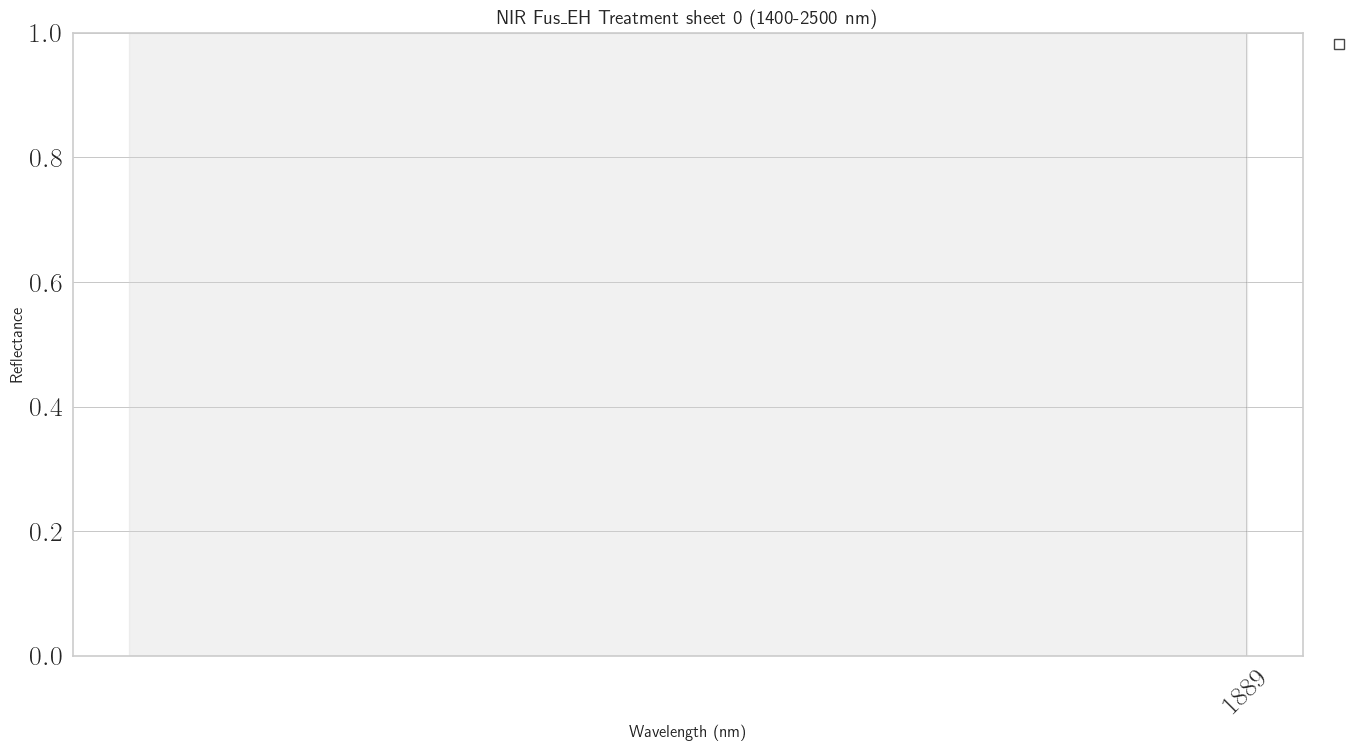

In [13]:
# Set up a larger figure with a good aspect ratio
plt.figure(figsize=(14, 8))

# Get all unique plant values in Fus_EH treatment from df0
fus_plants = df0[df0['Tratamiento'] == 'Fus_EH']['Planta'].unique()

# Create a colormap that will visually distinguish plants
colors = plt.cm.viridis(np.linspace(0, 1, len(fus_plants)))

# Plot each plant's spectral signature
for i, plant in enumerate(fus_plants):
    plant_data = df0[(df0['Tratamiento'] == 'Fus_EH') & (df0['Planta'] == plant)][wavelengths]
    
    if not plant_data.empty:
        plt.plot(wavelengths, plant_data.values[0], 
                 color=colors[i], 
                 label=f'Plant {plant}',
                 alpha=0.7)

# Customize plot
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.title('NIR Fus_EH Treatment sheet 0 (1400-2500 nm)', fontsize=14)
plt.grid(True, alpha=0.3)

# Format x-axis with evenly spaced ticks
plt.xticks(np.linspace(min(wavelengths), max(wavelengths), 10), rotation=45)

# Create a more user-friendly legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Highlight regions of interest 
plt.axvspan(1800, 1889, color='lightgray', alpha=0.3)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

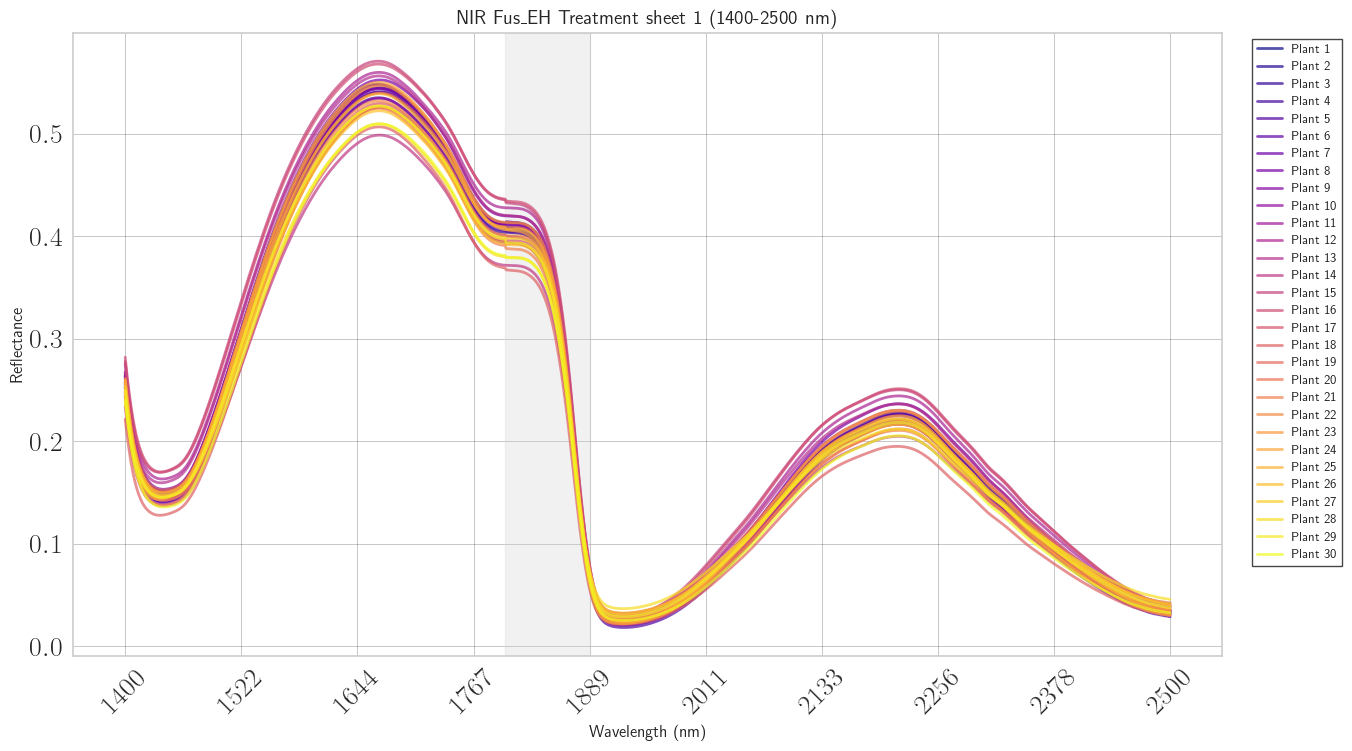

In [14]:
# Set up a larger figure with a good aspect ratio
plt.figure(figsize=(14, 8))

# Get all unique plant values in Fus_EH treatment from df1
fus_plants = df1[df1['Tratamiento'] == 'Fus_EH']['Planta'].unique()

# Create a colormap that will visually distinguish plants
colors = plt.cm.plasma(np.linspace(0, 1, len(fus_plants)))


# Plot each plant's spectral signature
for i, plant in enumerate(fus_plants):
    plant_data = df1[(df1['Tratamiento'] == 'Fus_EH') & (df1['Planta'] == plant)][wavelengths]
    
    if not plant_data.empty:
        plt.plot(wavelengths, plant_data.values[0], 
                 color=colors[i], 
                 label=f'Plant {plant}',
                 alpha=0.7)

# Customize plot
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.title('NIR Fus_EH Treatment sheet 1 (1400-2500 nm)', fontsize=14)
plt.grid(True, alpha=0.3)

# Format x-axis with evenly spaced ticks
plt.xticks(np.linspace(min(wavelengths), max(wavelengths), 10), rotation=45)

# Create a more user-friendly legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Highlight regions of interest 
plt.axvspan(1800, 1889, color='lightgray', alpha=0.3)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

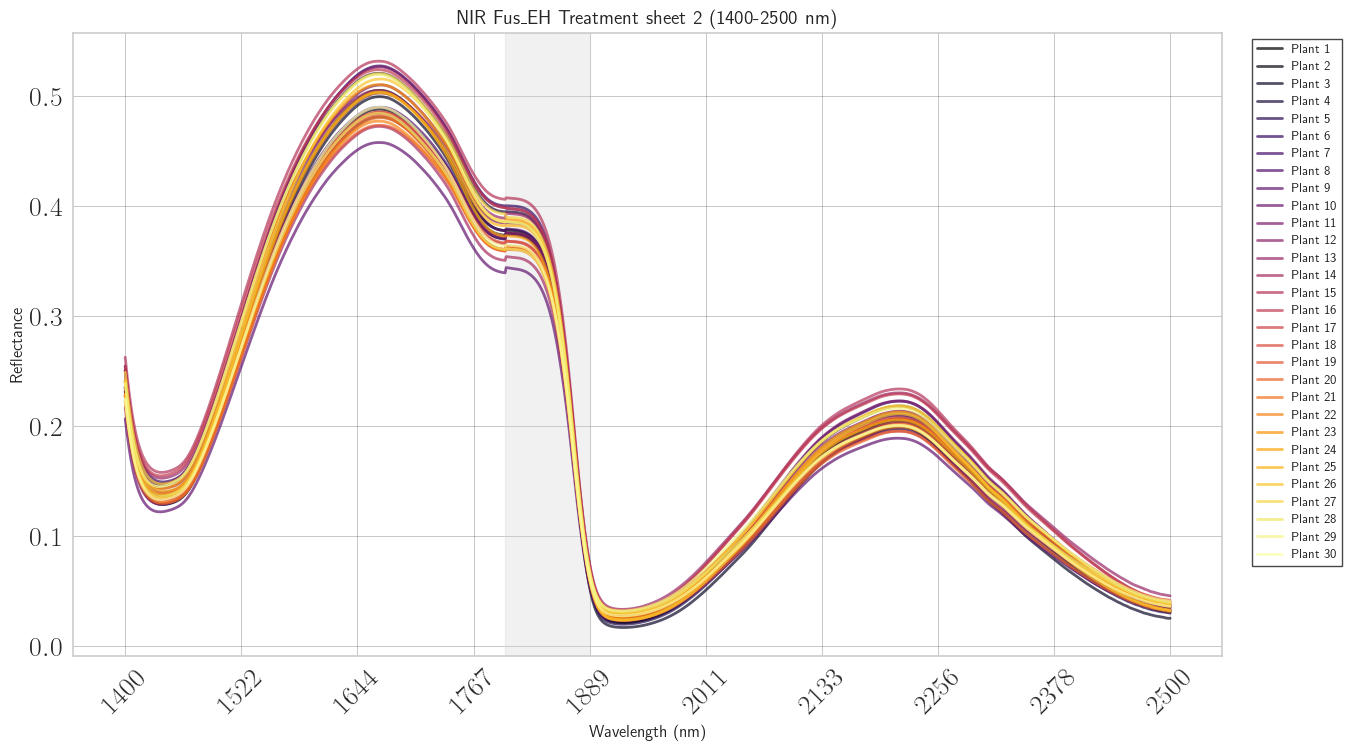

In [6]:
# Set up a larger figure with a good aspect ratio
plt.figure(figsize=(14, 8))

# Get all unique plant values in Fus_EH treatment from df2
fus_plants = df2[df2['Tratamiento'] == 'Fus_EH']['Planta'].unique()

# Create a colormap that will visually distinguish plants
colors = plt.cm.inferno(np.linspace(0, 1, len(fus_plants)))

# Plot each plant's spectral signature
for i, plant in enumerate(fus_plants):
    plant_data = df2[(df2['Tratamiento'] == 'Fus_EH') & (df2['Planta'] == plant)][wavelengths]
    
    if not plant_data.empty:
        plt.plot(wavelengths, plant_data.values[0], 
                 color=colors[i], 
                 label=f'Plant {plant}',
                 alpha=0.7)

# Customize plot
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.title('NIR Fus_EH Treatment sheet 2 (1400-2500 nm)', fontsize=14)
plt.grid(True, alpha=0.3)

# Format x-axis with evenly spaced ticks
plt.xticks(np.linspace(min(wavelengths), max(wavelengths), 10), rotation=45)

# Create a more user-friendly legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Highlight regions of interest 
plt.axvspan(1800, 1889, color='lightgray', alpha=0.3)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

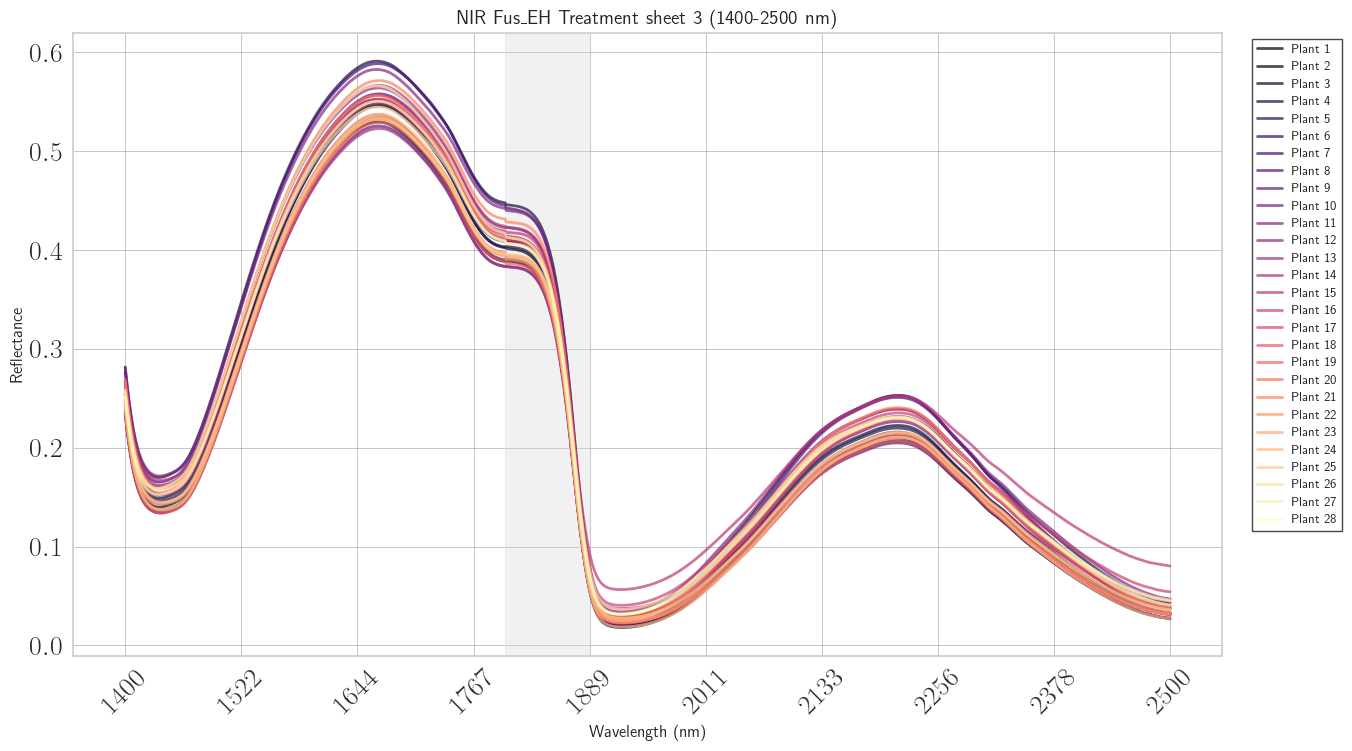

In [7]:
# Set up a larger figure with a good aspect ratio
plt.figure(figsize=(14, 8))

# Get all unique plant values in Fus_EH treatment from df3
fus_plants = df3[df3['Tratamiento'] == 'Fus_EH']['Planta'].unique()

# Create a colormap that will visually distinguish plants
colors = plt.cm.magma(np.linspace(0, 1, len(fus_plants)))

# Plot each plant's spectral signature
for i, plant in enumerate(fus_plants):
    plant_data = df3[(df3['Tratamiento'] == 'Fus_EH') & (df3['Planta'] == plant)][wavelengths]
    
    if not plant_data.empty:
        plt.plot(wavelengths, plant_data.values[0], 
                 color=colors[i], 
                 label=f'Plant {plant}',
                 alpha=0.7)

# Customize plot
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.title('NIR Fus_EH Treatment sheet 3 (1400-2500 nm)', fontsize=14)
plt.grid(True, alpha=0.3)

# Format x-axis with evenly spaced ticks
plt.xticks(np.linspace(min(wavelengths), max(wavelengths), 10), rotation=45)

# Create a more user-friendly legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Highlight regions of interest 
plt.axvspan(1800, 1889, color='lightgray', alpha=0.3)

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

## PCA and t-SNE without df0 (sheet 0)

### PCA

In [8]:
pca = PCA(n_components=2)

# The wavelength columns are from index 3 to the end
wavelength_data = df_Not0.iloc[:, 3:]

# Fit AND transform the data
pca_components = pca.fit_transform(wavelength_data)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Total explained variance: {explained_variance.sum():.2%}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_components,
    columns=['PC1', 'PC2']
)

# Add categorical columns for plotting
pca_df['Tratamiento'] = df_Not0['Tratamiento'].values
pca_df['Planta'] = df_Not0['Planta'].values

# Reorder columns to put Tratamiento and Planta first
pca_df = pca_df[['Tratamiento', 'Planta', 'PC1', 'PC2']]

# Direct PCA visualization approach (without using template)
plt.figure(figsize=(12, 8))

# Plot each treatment as a separate group
for treatment in pca_df['Tratamiento'].unique():
    subset = pca_df[pca_df['Tratamiento'] == treatment]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=treatment, alpha=0.7, s=60)

# Add proper labels that reflect PCA meaning
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1%} variance)')
plt.title('PCA: Treatment Groups in PC Space')
plt.legend(title='Treatment')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'df_Not0' is not defined

In [ ]:
pca = PCA(n_components=3)

# The wavelength columns are from index 3 to the end
wavelength_data = df_Not0.iloc[:, 3:]

# Fit AND transform the data
pca_components_3d = pca.fit_transform(wavelength_data)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Explained variance by PC3: {explained_variance[2]:.2%}")
print(f"Total explained variance: {explained_variance.sum():.2%}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_components_3d,
    columns=['PC1', 'PC2', 'PC3']
)

# Add categorical columns for plotting
pca_df['Tratamiento'] = df_Not0['Tratamiento'].values
pca_df['Planta'] = df_Not0['Planta'].values

# Reorder columns to put Tratamiento and Planta first
pca_df = pca_df[['Tratamiento', 'Planta', 'PC1', 'PC2', 'PC3']]


# Create the figure and 3D axes
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Get unique treatments for color mapping
treatments = pca_df['Tratamiento'].unique()

# First plot all non-Fusarium treatments
for treatment in treatments:
    subset = pca_df[pca_df['Tratamiento'] == treatment]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
                label=treatment, alpha=0.6, s=60, edgecolor='w')


# Set axis labels with explained variance
ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)', fontsize=12)
ax.set_zlabel(f'PC3 ({explained_variance[2]:.1%} variance)', fontsize=12)

# Set title and legend
ax.set_title('3D PCA: Treatment Groups with Highlighted Fusarium Outlier', fontsize=14)
ax.legend(title='Treatment', loc='upper right', bbox_to_anchor=(1.1, 1))

# Improve perspective
ax.view_init(elev=30, azim=45)
ax.dist = 5

# Add grid for better depth perception
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### T-SNE 

In [ ]:
# The wavelength columns are from index 3 to the end
wavelength_data = df_Not0.iloc[:, 3:]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(wavelength_data)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(
    data=tsne_results,
    columns=['t-SNE1', 't-SNE2']
)

# Add categorical columns for plotting
tsne_df['Tratamiento'] = df_Not0['Tratamiento'].values
tsne_df['Planta'] = df_Not0['Planta'].values

# Plot t-SNE results
plt.figure(figsize=(12, 8))

# Plot each treatment as a separate group
for treatment in tsne_df['Tratamiento'].unique():
    subset = tsne_df[tsne_df['Tratamiento'] == treatment]
    plt.scatter(subset['t-SNE1'], subset['t-SNE2'], 
                label=treatment, alpha=0.7, s=60)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Treatment Groups in Reduced Space')
plt.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Create the t-SNE model and transform the data
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_results_3d = tsne_3d.fit_transform(wavelength_data)

tsne_df = pd.DataFrame(
    tsne_results_3d, 
    columns=['Component 1', 'Component 2', 'Component 3']
)

tsne_df['Tratamiento'] = df_Not0['Tratamiento'].values 

# Create 3D plot
fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection='3d')

# 3. Now, loop and plot using the new, clean 'tsne_df'
for treatment in tsne_df['Tratamiento'].unique():
    # Filter the new DataFrame
    subset = tsne_df[tsne_df['Tratamiento'] == treatment] 
    
    # Plot using the named columns
    ax.scatter(subset['Component 1'], subset['Component 2'], subset['Component 3'], 
               label=treatment, alpha=0.7, s=60)

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D t-SNE: Treatment Groups')
ax.legend(title='Treatment')
plt.show()

# Trustworthiness calculation

In [ ]:
# Use the same parameters as you did for t-SNE for fair comparison
pca_trust_score = trustworthiness(wavelength_data, pca_components, n_neighbors=30)
print(f"PCA trustworthiness : {pca_trust_score:.4f}")

# Use the same parameters 
pca_3d_trust_score = trustworthiness(wavelength_data, pca_components_3d, n_neighbors=30)
print(f"PCA 3D trustworthiness : {pca_3d_trust_score:.4f}")

# Trustworthiness calculation
tsne_trust_score = trustworthiness(wavelength_data, tsne_results, n_neighbors=30)
print(f"Trustworthiness of t-SNE 2d: {tsne_trust_score:.4f}")

tsne_3d_trust_score = trustworthiness(wavelength_data, tsne_results_3d, n_neighbors=30)
print(f"Trustworthiness of t-SNE 3d: {tsne_3d_trust_score:.4f}")

# Models without treatment 'Fus_EH' (df0)

In [ ]:
# data treatment

# Data preparation for model production
X = df_NotFEH0.iloc[:, 3:].values  
y = df_NotFEH0['Tratamiento'].values  

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

## KNN without df0

In [ ]:
# Define the parameter grid
param_grid = {
    'pca__n_components': [10, 20, 30],            
    'knn__n_neighbors': list(range(1, 10)),          
    'knn__weights': ['uniform', 'distance'],          
    'knn__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'knn__algorithm': ['auto','ball_tree', 'kd_tree', 'brute'], 
    'knn__leaf_size': [10, 30, 50]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('knn', KNeighborsClassifier())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)


In [ ]:
print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred = best_model.predict(X_test)

In [ ]:
# ---------- PLOT 1: CONFUSION MATRIX ----------
plt.figure(figsize=(16, 12))

# Enhanced confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = sorted(df['Tratamiento'].unique())

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', colorbar=True, xticks_rotation=45)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=18)
plt.xlabel('Predicted Treatment', fontsize=14)
plt.ylabel('True Treatment', fontsize=14)

# Add value annotations to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if plt.cm.viridis(cm[i, j]/cm.max())[0] < 0.5 else 'black'
        plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ---------- PLOT 2: CLASSIFICATION REPORT ----------
plt.figure(figsize=(14, 10))

# Enhanced classification report visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop('accuracy', errors='ignore')  # Remove the accuracy row

# Create heatmap for classification metrics
ax = sns.heatmap(report_df.iloc[:-3, :3], annot=True, cmap='YlGnBu', fmt='.2f', 
        linewidths=0.5, cbar=True, annot_kws={"size": 12})
plt.title('Classification Report Metrics by Treatment', fontsize=18)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Treatment', fontsize=14)

# Add a text box with overall model performance
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
textstr = (f'Model: KNN (k={grid_search.best_params_["knn__n_neighbors"]})\n'
           f'Accuracy: {accuracy:.2%}\n'
           f'Macro Avg F1: {report["macro avg"]["f1-score"]:.2f}\n'
           f'Weighted Avg F1: {report["weighted avg"]["f1-score"]:.2f}')
plt.gcf().text(0.75, 0.25, textstr, fontsize=14,
        verticalalignment='center', bbox=props)

# Add the summary metrics at the bottom
summary_df = report_df.iloc[-3:, :3]
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap='YlGnBu', fmt='.2f',
           linewidths=0.5, cbar=False, annot_kws={"size": 12})
plt.title('Summary Metrics', fontsize=16)

plt.tight_layout()
plt.show()

# Print additional performance details
print(f"Overall model accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## SVM without df0

In [ ]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 30, 40],
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svm__degree': [2, 3, 4],
    'svm__class_weight': ['balanced', None]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('svm', SVC())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)

In [ ]:
print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred = best_model.predict(X_test)

In [ ]:
# ---------- PLOT 1: CONFUSION MATRIX ----------
plt.figure(figsize=(16, 12))

# Enhanced confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = sorted(df['Tratamiento'].unique())

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', colorbar=True, xticks_rotation=45)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=18)
plt.xlabel('Predicted Treatment', fontsize=14)
plt.ylabel('True Treatment', fontsize=14)

# Add value annotations to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if plt.cm.viridis(cm[i, j]/cm.max())[0] < 0.5 else 'black'
        plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ---------- PLOT 2: CLASSIFICATION REPORT ----------
plt.figure(figsize=(14, 10))

# Enhanced classification report visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop('accuracy', errors='ignore')  # Remove the accuracy row

# Create heatmap for classification metrics
ax = sns.heatmap(report_df.iloc[:-3, :3], annot=True, cmap='YlGnBu', fmt='.2f', 
        linewidths=0.5, cbar=True, annot_kws={"size": 12})
plt.title('Classification Report Metrics by Treatment', fontsize=18)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Treatment', fontsize=14)

# Add a text box with overall model performance
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
textstr = (f'Model: SVM (C={grid_search.best_params_["svm__C"]}, kernel={grid_search.best_params_["svm__kernel"]})\n'
           f'Accuracy: {accuracy:.2%}\n'
           f'Macro Avg F1: {report["macro avg"]["f1-score"]:.2f}\n'
           f'Weighted Avg F1: {report["weighted avg"]["f1-score"]:.2f}')
plt.gcf().text(0.75, 0.25, textstr, fontsize=14,
        verticalalignment='center', bbox=props)

# Add the summary metrics at the bottom
summary_df = report_df.iloc[-3:, :3]
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap='YlGnBu', fmt='.2f',
           linewidths=0.5, cbar=False, annot_kws={"size": 12})
plt.title('Summary Metrics', fontsize=16)

plt.tight_layout()
plt.show()

# Print additional performance details
print(f"Overall model accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))